In [12]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
class StationaryTestbed:
    def __init__(self, k, unit_variances=True):
        self.k = k
        self.means = [np.random.uniform(-3.0, 10.0) for _ in range(self.k)]
        if unit_variances:
            self.std_devs = [1.0 for _ in range(self.k)]
        else:
            self.std_devs = [np.random.uniform(0, 1.5) for _ in range(self.k)]

    def get_reward(self, action):
      reward = np.random.normal(loc=self.means[action], scale=self.std_devs[action])
      return reward

    def plot_reward_distributions(self, num_datapoints=10000):
        reward_distributions = [
            np.random.normal(loc=mean, scale=std, size=num_datapoints)
            for mean, std in zip(self.means, self.std_devs)
        ]
        plt.figure(figsize=(12, 8))
        parts = plt.violinplot(reward_distributions, showmeans=False, showmedians=False, showextrema=False)

        for pc in parts['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)

        for i, mean in enumerate(self.means):
            plt.hlines(mean, i + 0.8, i + 1.2, color='red', linewidth=2)
            plt.text(i + 1.25, mean, f"$q^*(a_{{{i+1}}})={mean:.2f}$", color='red', fontsize=10, va='center')

        plt.axhline(0, color='black', linestyle='--')
        plt.xticks(range(1, self.k + 1), [f'Dist {i+1}' for i in range(self.k)])
        plt.ylabel('Reward Value')
        plt.title('Violin Plots of Reward Distributions')
        plt.show()

In [14]:
class NonStationaryTestbed:
    """Parameters are (too) specific to Exercise 2.6 (Reinforcement Learning, Sutton & Barto)"""
    def __init__(self, k, random_walk_mean=0.0, random_walk_std=0.01):
        self.k = k
        self.means = [0.0 for _ in range(self.k)]
        self.std_devs = [1.0 for _ in range(self.k)]
        self.random_walk_mean = random_walk_mean
        self.random_walk_std = random_walk_std

    def get_reward(self, action):
      reward = np.random.normal(loc=self.means[action], scale=self.std_devs[action])
      return reward

    def random_walk(self):
      self.means = [
          mean + np.random.normal(loc=self.random_walk_mean, scale=self.random_walk_std)
          for mean in self.means
      ]

    def plot_reward_distributions(self, num_datapoints=10000):
        reward_distributions = [
            np.random.normal(loc=mean, scale=std, size=num_datapoints)
            for mean, std in zip(self.means, self.std_devs)
        ]
        plt.figure(figsize=(12, 8))
        parts = plt.violinplot(reward_distributions, showmeans=False, showmedians=False, showextrema=False)

        for pc in parts['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)

        for i, mean in enumerate(self.means):
            plt.hlines(mean, i + 0.8, i + 1.2, color='red', linewidth=2)
            plt.text(i + 1.25, mean, f"$q^*(a_{{{i+1}}})={mean:.2f}$", color='red', fontsize=10, va='center')

        plt.axhline(0, color='black', linestyle='--')
        plt.xticks(range(1, self.k + 1), [f'Dist {i+1}' for i in range(self.k)])
        plt.ylabel('Reward Value')
        plt.title('Violin Plots of Reward Distributions')
        plt.show()

In [15]:
testbed = NonStationaryTestbed(k=10)

In [21]:
# class Bandit:

#   def __init__(self,
#                k,
#                testbed,
#                exploration='epsilon',
#                time_steps=1000,
#                epsilon=0.1,
#                problem_type='stationary',
#                step_size=0.1
#                ):
#     self.k = k
#     self.time_steps = time_steps
#     if exploration == 'epsilon':
#       self.epsilon = epsilon
#     self.problem_type = problem_type
#     self.actions = [i for i in range(self.k)]
#     self.Q_values = [0 for _ in range(self.k)]
#     if step_size is None:
#       self.N_values = [0 for _ in range(self.k)]
#     else:
#       self.N_values = None
#       self.step_size = step_size

#     self.rewards = []
#     self.testbed = testbed
class Bandit:
  def __init__(self,
               k,
               testbed,
               exploration='epsilon',
               time_steps=1000,
               epsilon=0.1,
               problem_type='stationary',
               step_size=0.1
               ):
    self.k = k
    self.time_steps = time_steps
    if exploration == 'epsilon':
        self.epsilon = epsilon
    self.problem_type = problem_type
    self.actions = [i for i in range(self.k)]
    self.Q_values = [0 for _ in range(self.k)]

    # Always set step_size
    self.step_size = step_size
    if self.step_size is None:
        self.N_values = [0 for _ in range(self.k)]
    else:
        self.N_values = None

    self.rewards = []
    self.testbed = testbed


  def run(self):
    rewards = []
    for _ in range(self.time_steps):
      if np.random.random() < self.epsilon:
        action = np.random.choice(self.actions)
      else:
        action = np.argmax(self.Q_values)
      reward = self.testbed.get_reward(action)
      if self.problem_type == 'nonstationary':
        self.testbed.random_walk()
      if self.step_size is not None:
        self.Q_values[action] += (reward - self.Q_values[action]) * self.step_size
      else:
        self.N_values[action] += 1
        self.Q_values[action] += (reward - self.Q_values[action]) / self.N_values[action]
      rewards.append(reward)

    return rewards

In [22]:
import joblib

class Bandits:
  """Essentially a wrapper to run multiple Bandit experiments and average their results."""
  def __init__(self,
               k,
               testbed,
               exploration='epsilon',
               epsilon=0.1,
               time_steps=10000,
               num_runs=2000,
               problem_type='nonstationary',
               step_size=0.1
               ):
    self.k = k
    self.testbed = testbed
    self.exploration = exploration
    self.epsilon = epsilon
    self.time_steps = time_steps
    self.num_runs = num_runs
    self.problem_type = problem_type
    self.step_size = step_size
    self.rewards = []
    self.mean_rewards = None

  def run(self):
    for _ in range(self.num_runs):
      bandit = Bandit(
          k=self.k,
          testbed=self.testbed,
          exploration=self.exploration,
          epsilon=self.epsilon,
          time_steps=self.time_steps,
          problem_type=self.problem_type,
          step_size=self.step_size
      )
      self.rewards.append(bandit.run())
    self.mean_rewards = np.array(self.rewards).mean(axis=0)

  def save_results(self, filename):
    joblib.dump({
        'rewards': self.rewards,
        'mean_rewards': self.mean_rewards
    }, f'{filename}.pkl')

  def plot_mean_rewards(self):
    plt.figure(figsize=(12, 8))
    plt.plot(self.mean_rewards)
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.show()

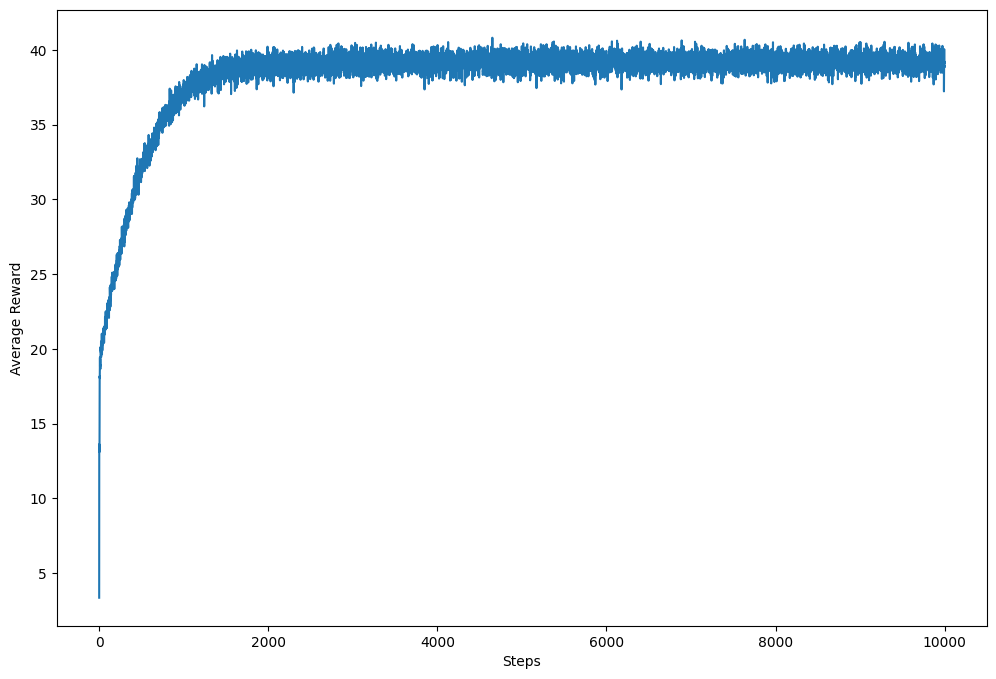

In [18]:
bandits = Bandits(
    k=10,
    testbed=testbed,
    epsilon=0.1,
    step_size=0.1
)
bandits.run()
bandits.plot_mean_rewards()

In [19]:
mean_rewards = []
mean_rewards.append(bandits.mean_rewards)

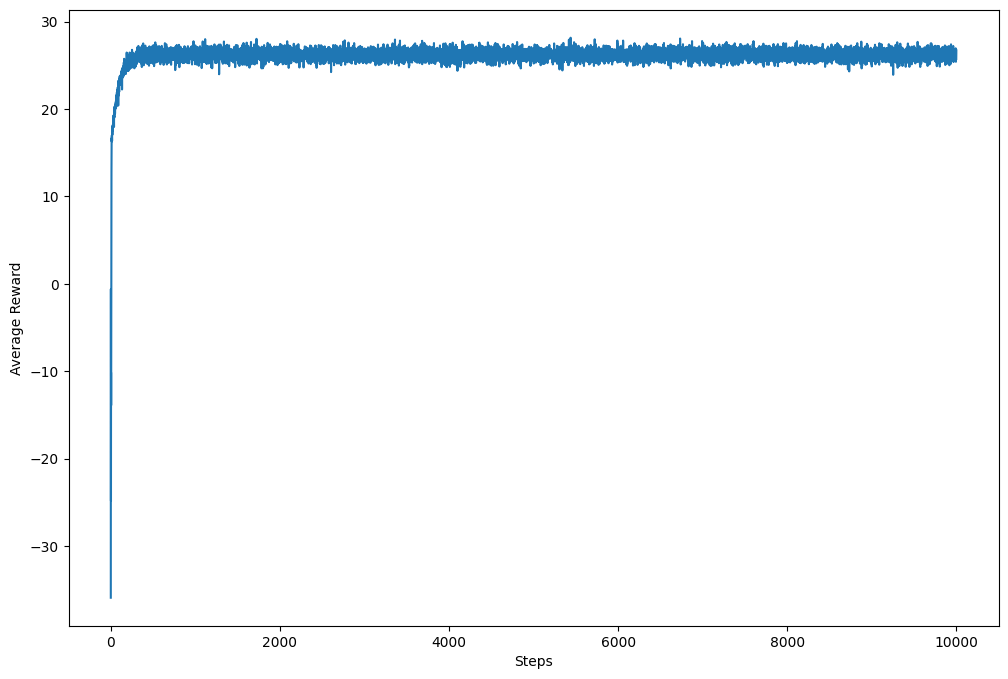

In [23]:
bandits = Bandits(
    k=10,
    testbed=testbed,
    epsilon=0.1,
    step_size=None
)
bandits.run()
bandits.plot_mean_rewards()

In [24]:
mean_rewards.append(bandits.mean_rewards)

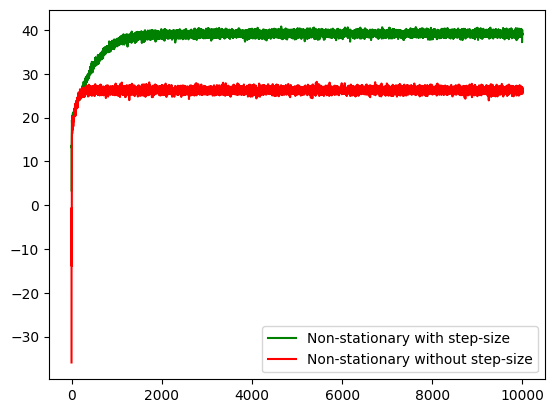

In [25]:
plt.plot(mean_rewards[0], label='Non-stationary with step-size', color='green')
plt.plot(mean_rewards[1], label='Non-stationary without step-size', color='red')
plt.legend()
plt.show()